# 2020 T2 COMP9417 Group Project

## Group Member  
* Shu Yang (z5172181)  
* Yue Qi (z5219951)  
* Tim Luo (z5115679) 
* Yixiao Zhan (z5210796)


## Topic Overview
In a world… where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

A link to this Kaggle competition is provided below 
> https://www.kaggle.com/c/tmdb-box-office-prediction/overview

## Date pre-processing 
Import the relevant packages we'll need for this project.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
import json
import ast
import math
from collections import Counter
from ast import literal_eval
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model

Read in training and test data  


In [2]:
train = pd.read_csv("./Data/train.csv")
test = pd.read_csv("./Data/test.csv")

### Yue's part
Yue is working on data pre-processing for columns from id to production company

In [3]:
# setting some global value
drop_list_Yue = []

### Need to fill in some missing values for budget and revenue as these are important features

In [4]:
# Add in missing values for budget and revenue
# Referencing: https://www.kaggle.com/kamalchhirang/tmdb-box-office-prediction-more-training-data
# Training Set
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5
train.loc[train['id'] == 1282,'budget'] = 9              # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1
train.loc[train['id'] == 2696,'budget'] = 10000000

# Test Set
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4
test.loc[test['id'] == 3594,'budget'] = 25
test.loc[test['id'] == 3619,'budget'] = 500
test.loc[test['id'] == 3831,'budget'] = 3
test.loc[test['id'] == 3935,'budget'] = 500
test.loc[test['id'] == 4049,'budget'] = 995946
test.loc[test['id'] == 4424,'budget'] = 3
test.loc[test['id'] == 4460,'budget'] = 8
test.loc[test['id'] == 4555,'budget'] = 1200000
test.loc[test['id'] == 4624,'budget'] = 30
test.loc[test['id'] == 4645,'budget'] = 500
test.loc[test['id'] == 4709,'budget'] = 450
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40
test.loc[test['id'] == 5035,'budget'] = 1
test.loc[test['id'] == 5063,'budget'] = 14
test.loc[test['id'] == 5119,'budget'] = 2
test.loc[test['id'] == 5214,'budget'] = 30
test.loc[test['id'] == 5221,'budget'] = 50
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3
test.loc[test['id'] == 5469,'budget'] = 20
test.loc[test['id'] == 5840,'budget'] = 1
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8
test.loc[test['id'] == 6759,'budget'] = 50
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

#### collection
Relationship between revenue and collection.
Movies with collection have more revenue

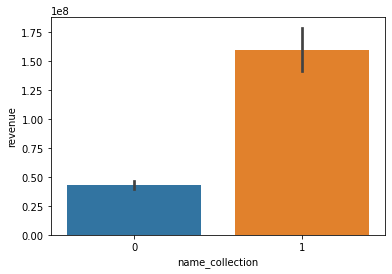

In [5]:

train['belongs_to_collection'].fillna(0, inplace=True)
draw_train = train
draw_train['newbelongs_to_collection'] = draw_train['belongs_to_collection'].apply(lambda x: literal_eval(x) if x != 0 else 0)
draw_train['name_collection'] = draw_train['newbelongs_to_collection'].apply(lambda x: 1 if x != 0 else 0)
sns.barplot(x='name_collection',y='revenue',data=draw_train)

In [6]:
train['belongs_to_collection'].fillna(0, inplace=True)
test['belongs_to_collection'].fillna(0, inplace=True)


def checkBelongs(target_list):
    # change the json into dic
    target_list['newbelongs_to_collection'] = target_list['belongs_to_collection'].apply(lambda x: literal_eval(x) if x != 0 else 0)

    # add one more collection name to store the collection name
    target_list['name_collection'] = target_list['newbelongs_to_collection'].apply(lambda x: x[0]['name'] if x != 0 else '0')
    # lable encoder
    le = LabelEncoder()
    le.fit(list(target_list['name_collection'].fillna('')))
    target_list['name_collection'] = le.transform(target_list['name_collection'].fillna('').astype(str))

checkBelongs(train)
checkBelongs(test)
# drop the old belongs_to_collection and newbelongs_to_collection
drop_list_Yue.append('newbelongs_to_collection')
drop_list_Yue.append('belongs_to_collection')
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,newbelongs_to_collection,name_collection
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",152
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,"[{'id': 107674, 'name': 'The Princess Diaries ...",366
2,3,0,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,1
3,4,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,1
4,5,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,1


#### budget
McKenzie (2012) believes that the relationship between budget and movie success is critical importance. So we choose to keep the 0 budget if the budget of this movie is not certain.

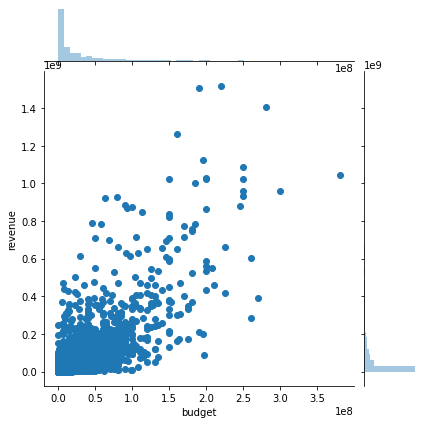

In [7]:
# checkout budget
train['budget'].fillna(0, inplace=True)
test['budget'].fillna(0, inplace=True)
sns.jointplot(x="budget", y="revenue", data=train)

#### genres

In [8]:
# checkout genres
train['genres'].fillna(0, inplace=True)
test['genres'].fillna(0, inplace=True)
# change the json into dic
train['new_genres'] = train['genres'].apply(lambda x: literal_eval(x) if x != 0 else 0)
test['new_genres'] = test['genres'].apply(lambda x: literal_eval(x) if x != 0 else 0)

train['new_genres'].apply(lambda x: len(x) if x != 0 else 0).value_counts()
# only 7 movies don't have the genres

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: new_genres, dtype: int64

In [9]:
# check each genres for each movie
def check_genre(target_list):
    list_of_genres = list(target_list['new_genres'].apply(lambda x: [i['name'] for i in x] if x != 0 else []).values)
    target_list['all_genres'] = target_list['new_genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != 0 else '')
    generes_list = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common()]
    for g in generes_list:
        target_list['genre_' + g] = target_list['all_genres'].apply(lambda x: 1 if g in x else 0)

check_genre(train)
check_genre(test)
drop_list_Yue.append('genres')
drop_list_Yue.append('new_genres')
drop_list_Yue.append('all_genres')

#### homepage

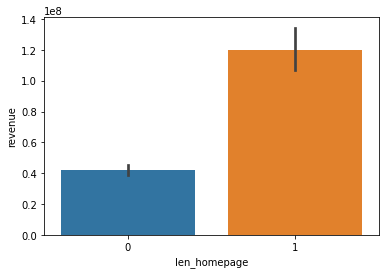

In [10]:
train['homepage'].fillna(0, inplace=True)
test['homepage'].fillna(0, inplace=True)

train['len_homepage'] = train['homepage'].apply(lambda x: 1 if x != 0 else 0)
sns.barplot(x='len_homepage',y='revenue',data=train)

From the bar chart, the movie with homepage has more revenue.

In [11]:
# we transform homepage into boolean
train['len_homepage'] = train['homepage'].apply(lambda x: 1 if x != 0 else 0)
test['len_homepage'] = test['homepage'].apply(lambda x: 1 if x != 0 else 0)
# drop the origin data
drop_list_Yue.append('homepage')

#### imdb_id

In [12]:
# checkout imdb_id
train['imdb_id'].apply(lambda x: len(x) if x != 0 else 0).value_counts()

9    3000
Name: imdb_id, dtype: int64

Since every movie has its own imdb_id which is unique to each movie, we can ignore this attribute.

In [13]:
drop_list_Yue.append('imdb_id')

#### original_language

In [14]:
# checkout original_language
train['original_language'].apply(lambda x: x if x != 0 else 0).value_counts()

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
de      18
ta      16
sv       8
pt       6
nl       6
da       5
fa       5
ro       4
tr       3
hu       3
no       2
ml       2
te       2
pl       2
fi       2
mr       1
ur       1
id       1
nb       1
ar       1
he       1
bn       1
el       1
sr       1
vi       1
cs       1
Name: original_language, dtype: int64

In [15]:
def checkLanguage(target_list):
    # lable encoder
    le = LabelEncoder()
    le.fit(list(target_list['original_language'].fillna('')))
    target_list['langua_type'] = le.transform(target_list['original_language'].fillna('').astype(str))

checkLanguage(train)
checkLanguage(test)
# drop the origin data
drop_list_Yue.append('original_language')

#### original_title

In [16]:
# check the whether title has been changed, check the title length
def checkTitle(target_list):
    # check whether equal
    target_list['original_title'].fillna('')
    target_list['ortitle_equal'] = 1
    target_list.loc[ target_list['original_title'] == target_list['title'] ,"ortitle_equal"] = 0 
    
    # title length account
    target_list['original_title_length'] = target_list['original_title'].str.len() 
    target_list['original_title_word'] = target_list['original_title'].str.split().str.len()

checkTitle(train)
checkTitle(test)
drop_list_Yue.append('original_language')

#### overview

In [17]:
# check the overview length
def checkOverview(target_list):
    # title length account
    target_list['overview_length'] = target_list['overview'].str.len() 
    target_list['overview_word'] = target_list['overview'].str.split().str.len()

checkOverview(train)
checkOverview(test)
drop_list_Yue.append('overview')

#### popularity

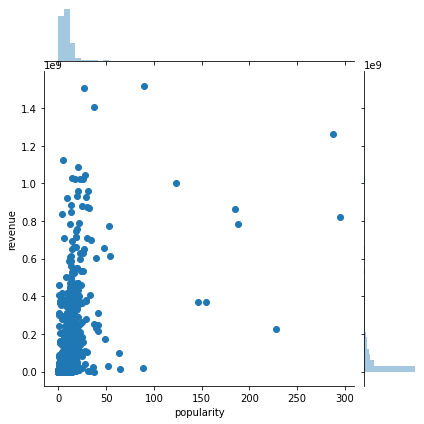

In [18]:
# Show the relationship between popularity and revenue
train['popularity'].fillna(0, inplace=True)
test['popularity'].fillna(0, inplace=True)
sns.jointplot(x="popularity", y="revenue", data=train)

#### poster_path
We ignore the 'poster_path'. Even the poster should have some effect on motivating cutomers to watch movie. The anaylsis for image is a tough work. Besides, our concentration is focusing on the data that we can manipulate. Hence, we drop the img.

In [19]:
drop_list_Yue.append('poster_path')

#### production_companies

In [20]:
# checkout production_companies
# fill the NaN
train['production_companies'].fillna(0, inplace=True)
test['production_companies'].fillna(0, inplace=True)
# change the json into dic
train['newproduction_companies'] = train['production_companies'].apply(lambda x: literal_eval(x) if x != 0 else 0)

test['newproduction_companies'] = test['production_companies'].apply(lambda x: literal_eval(x) if x != 0 else 0)

train['newproduction_companies'].apply(lambda x: len(x) if x != 0 else 0).value_counts()

1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: newproduction_companies, dtype: int64

In [21]:
# check each production_companies for each movie
def check_produc_com(target_list):
    list_of_prodc = list(target_list['newproduction_companies'].apply(lambda x: [i['name'] for i in x] if x != 0 else []).values)
    target_list['all_prodc'] = target_list['newproduction_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != 0 else '')
    prodc_list = [m[0] for m in Counter([i for j in list_of_prodc for i in j]).most_common()]
    for g in prodc_list:
        target_list['prodc_' + g] = target_list['all_prodc'].apply(lambda x: 1 if g in x else 0)

check_produc_com(train)
check_produc_com(test)
drop_list_Yue.append('production_companies')
drop_list_Yue.append('newproduction_companies')
drop_list_Yue.append('all_prodc')

In [22]:
# drop the origin data
# train.drop(np.unique(drop_list_Yue), axis = 1, inplace = True)
# test.drop(np.unique(drop_list_Yue), axis = 1, inplace = True)
# train.head()

### Yixiao's part
Yixiao is working on data pre-processing for columns from production country to production company keywords

#### Production countries

In [23]:
# Separate and extract country name from production_countries
train['production_countries_count'] = train['production_countries'].apply(lambda x: len(ast.literal_eval(x)) if x == x else 0)
train['all_produced_countries'] = train['production_countries'].apply(lambda x: ",".join(sorted([i['name'] for i in ast.literal_eval(x)])) if x == x else '')

# Calculate mean revenue for these movies
revenue_means = {}
for value in train['all_produced_countries'].unique():
    query = "all_produced_countries=='" + value + "'"
    revenue_means[value] = round(train.query(query)['revenue'].mean(),2)

# Print the top 10 mean revenue
counter = Counter(revenue_means)
print ("TOP 10 revenue by production countries\n")
for v in counter.most_common(10):
    countries, mean_revenue = v
    print("Movie produced from " + countries + " has mean revenue " + str(mean_revenue))

TOP 10 revenue by production countries

Movie produced from Czech Republic,United Arab Emirates,United States of America has mean revenue 694713380.0
Movie produced from New Zealand,United States of America has mean revenue 607134808.86
Movie produced from Czech Republic,Germany,Italy,United Kingdom,United States of America has mean revenue 599045960.0
Movie produced from Germany,New Zealand,United States of America has mean revenue 550000000.0
Movie produced from Canada,Hong Kong,Taiwan,United States of America has mean revenue 532950503.0
Movie produced from Malta,United States of America has mean revenue 531865000.0
Movie produced from Czech Republic,Poland,Slovenia,United States of America has mean revenue 419651413.0
Movie produced from Australia,Canada,China,Hong Kong,United States of America has mean revenue 331957105.0
Movie produced from Australia,Canada,France,Germany has mean revenue 312242626.0
Movie produced from Czech Republic,United States of America has mean revenue 300

We see from the above value counts that most movies are made by Czech Republic,United Arab Emirates,United States of America

In [24]:
# Add columns produced_by_USA if needed

# train["produced_by_USA"] = train["all_countries"].apply(lambda x: 1 if "United States of America" in x else 0)

#### Release date
Break release into month, day and year and derive release_dayofweek from the date
Add all these information to separate columns in train dataframe

In [25]:
# Release date data preprocessing
# Split release month, day, year into sepearte columns
train[["release_month","release_day","release_year"]] = train["release_date"].str.split("/",expand=True).replace(np.nan, -1).astype(int)
# Change release year to 4 digits year
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900
release_date = pd.to_datetime(train["release_date"])
# Add the derived release weekday name to train
train["release_dayofweek"] = release_date.dt.weekday_name

AttributeError: 'DatetimeProperties' object has no attribute 'weekday_name'

In [ ]:
# Encode release_dayofweek
encoder = preprocessing.LabelBinarizer()
release_dayofweek_transformed = encoder.fit_transform(train["release_dayofweek"])
release_dayofweek = pd.DataFrame(release_dayofweek_transformed)
# Add to train dataframe
train = pd.concat([train,release_dayofweek], axis=1)

# Rename column name for easier use
train.rename(columns={0 : "released_on_" + str(encoder.classes_[0]), 1 : "released_on_" + str(encoder.classes_[1]), 2 : "released_on_" + str(encoder.classes_[2]),3 : "released_on_" + str(encoder.classes_[3]),4 : "released_on_" + str(encoder.classes_[4]),5 : "released_on_" + str(encoder.classes_[5]),6 : "released_on_" + str(encoder.classes_[6])},inplace=True)

release_month_transformed = encoder.fit_transform(train["release_month"])
release_month = pd.DataFrame(release_month_transformed)
# Add to train dataframe
train = pd.concat([train,release_month], axis=1)

# Rename column name for easier use
train.rename(columns={0 : "released_on_" + "Jan", 1 : "released_on_" + "Feb", 2 : "released_on_" + "Mar",3 : "released_on_" + "Apr",4 : "released_on_" + "May",5 : "released_on_" + "Jun",6 : "released_on_" + "Jul",7 : "released_on_" + "Aug", 8 : "released_on_" + "Sep", 9 : "released_on_" + "Oct",10 : "released_on_" + "Nov",11 : "released_on_" + "Dec"},inplace=True)

#### runtime

In [ ]:
print(train["runtime"].isnull().values.sum(), "null values found before filling na" )
median = train["runtime"].median()
train["runtime"].fillna(median,inplace=True)
print(train["runtime"].isnull().values.sum(), "null values found after filling na" )
train.plot(x="runtime",y="revenue",kind="scatter")
plt.show()

#### Spoken language

In [ ]:
# Separate and extract country name from production_countries
train['spoken_languages_count'] = train['spoken_languages'].apply(lambda x: len(ast.literal_eval(x)) if x == x else 0)
train['all_spoken_languages'] = train['spoken_languages'].apply(lambda x: ",".join(sorted([i['name'] for i in ast.literal_eval(x)])) if x == x else '')

# Calculate mean revenue for these movies
revenue_means = {}
for value in train['all_spoken_languages'].unique():
    query = "all_spoken_languages=='" + value + "'"
    revenue_means[value] = round(train.query(query)['revenue'].mean(),2)

# Print the top 10 mean revenue
counter = Counter(revenue_means)
print ("TOP 10 revenue by spoken languages\n")
for v in counter.most_common(10):
    languages, mean_revenue = v
    print("Movie of spoken language " + languages + " has mean revenue " + str(mean_revenue))

Encode the month and release_dayofweek to become boolean value (e.g. release_on_Wed, release_on_June)

#### Status

In [ ]:
# Sum revenue of all released movie
print ("Released movie mean revenue = " + str(train.query("status=='Released'")['revenue'].mean()))
# Sum revenue of all rumoured movie
print ("Rumored movie mean revenue = " + str(train.query("status=='Rumored'")['revenue'].mean()))

Clearly, released movies have a much higher mean revenue than rumored movie, therefore, we will create a column isReleased to our train dataframe

In [ ]:
train["is_released"] = np.where(train["status"]=="Released",1,0)
train.drop(columns=["status"],inplace=True)

#### Keywords

In [ ]:
# Separate and extract country name from production_countries
train['keywords_count'] = train['Keywords'].apply(lambda x: len(ast.literal_eval(x)) if x == x else 0)
train['all_keywords'] = train['Keywords'].apply(lambda x: ",".join(sorted([i['name'] for i in ast.literal_eval(x)])) if x == x else '')

# Calculate mean revenue for these movies
revenue_means = {}
for value in train['all_keywords'].unique():
    query = 'all_keywords=="' + value + '"'
    revenue_means[value] = round(train.query(query)['revenue'].mean(),2)

# Print the top 10 mean revenue
counter = Counter(revenue_means)
print ("TOP 10 revenue by keywords\n")
for v in counter.most_common(10):
    keywords, mean_revenue = v
    print("Movie of Keywords " + keywords + " has mean revenue " + str(mean_revenue))

### Tim's part
Tim is working on data-preprocessing for column cast

In [26]:
# Replaces cast dict with list of cast
def cast_list(cell):
    if isinstance(cell, str):
        cell_contents = cell[1:-1].replace('{','').replace('}','').replace('"','').replace('\'','').split(',')
        cell = [x.replace(' name: ','') for x in cell_contents if "name" in x]
    return cell

train['cast'] = train['cast'].map(cast_list)

In [27]:
# Grab revenues
def get_cast_members_with_revenues(df):
    cast_members = {}
    for index, movie in df.iterrows():
        if isinstance(movie['cast'], list):
            for cast in movie['cast']:
                if cast in cast_members:
                    revenue = cast_members[cast] + movie['revenue']
                    cast_members[cast] = revenue
                else:
                    cast_members[cast] = movie['revenue']
    return cast_members

# Grab how many times cast was actually cast
def cast_frequency(df):
    cast_list= []
    for index, movie in df.iterrows():
        if isinstance(movie['cast'], list):
            for cast in movie['cast']:
                cast_list.append(cast)
    unique, counts = np.unique(cast_list, return_counts=True)
    return dict(zip(unique, counts))

In [28]:
# This will also be used to rank cast based on revenue
cast_freq = cast_frequency(train)

In [29]:
cast_with_revenues = get_cast_members_with_revenues(train)

In [30]:
# Sort by largest revenue earners to smallest
import operator
sorted_cast_by_revenue = dict(sorted(cast_with_revenues.items(), key=operator.itemgetter(1),reverse=True))
sorted_cast_by_revenue

{'Samuel L. Jackson': 8705466670,
 'Ian McKellen': 6874126385,
 'Stan Lee': 6849525199,
 'Hugo Weaving': 6420063095,
 'Frank Welker': 5959117850,
 'Christopher Lee': 5768530784,
 'Andy Serkis': 5651895899,
 'Cate Blanchett': 5545209333,
 'Jess Harnell': 5225309690,
 'Judi Dench': 4916972469,
 'John Ratzenberger': 4746297600,
 'Jeremy Renner': 4645519685,
 'Johnny Depp': 4617172277,
 'Orlando Bloom': 4562967083,
 'Tyrese Gibson': 4534886528,
 'John Turturro': 4433580153,
 'Scarlett Johansson': 4399361563,
 'Alan Tudyk': 4310772959,
 'Idris Elba': 4284913037,
 'Vin Diesel': 4190841965,
 'Chris Evans': 4188028065,
 'Stellan Skarsg√•rd': 4149023692,
 'Luke Evans': 4105072051,
 'Shia LaBeouf': 4090590413,
 'Sean Bean': 4061020800,
 'Stanley Tucci': 4023100085,
 'Glenn Morshower': 4014307699,
 'Elijah Wood': 3939830019,
 'Bradley Cooper': 3864229926,
 'Robert Downey Jr.': 3818751246,
 'Paul Bettany': 3808360465,
 'Thomas Kretschmann': 3787780131,
 'Cobie Smulders': 3737426823,
 'Jim Broadben

In [31]:
# Convert to list
cast_rev = []
for key, value in sorted_cast_by_revenue.items():
    temp = [key, value]
    cast_rev.append(temp)

In [32]:
# Divide by frequency of occurence and then normalise
max_val = 0
for cast in cast_rev:
    cast[1] /= cast_freq[cast[0]]
    if (cast[1] > max_val):
        max_val = cast[1]

for cast in cast_rev:
    cast[1] /= max_val

In [33]:
# Convert back to dict
dict_cast = dict() 
for cast in cast_rev: 
    dict_cast[cast[0]] = cast[1]
dict_cast

{'Samuel L. Jackson': 0.19096489868775934,
 'Ian McKellen': 0.3231262357747195,
 'Stan Lee': 0.5634472001629737,
 'Hugo Weaving': 0.3249965032972599,
 'Frank Welker': 0.1960806432839404,
 'Christopher Lee': 0.29201462761677127,
 'Andy Serkis': 0.3719434357720529,
 'Cate Blanchett': 0.21466031807508912,
 'Jess Harnell': 0.4298379857402078,
 'Judi Dench': 0.24890703340258907,
 'John Ratzenberger': 0.24026712834169997,
 'Jeremy Renner': 0.3057152119329233,
 'Johnny Depp': 0.18990606768813437,
 'Orlando Bloom': 0.33364726623387164,
 'Tyrese Gibson': 0.3730432465058209,
 'John Turturro': 0.12156990211383256,
 'Scarlett Johansson': 0.20679706220795305,
 'Alan Tudyk': 0.3152066598253055,
 'Idris Elba': 0.25634926201541197,
 'Vin Diesel': 0.25072136486184865,
 'Chris Evans': 0.30623146943222895,
 'Stellan Skarsg√•rd': 0.24821954432786308,
 'Luke Evans': 0.3859272888313756,
 'Shia LaBeouf': 0.26919608565625514,
 'Sean Bean': 0.20557703877479427,
 'Stanley Tucci': 0.15573802394702455,
 'Glenn Mo

In [38]:
# Add a new column to training data which includes the score of each movie based on cast
# This score is simply the sum of the values of each cast

def get_cast_score(cell):
    cast_score = 0
    if isinstance(cell, list):
        for cast in cell:
            if cast in dict_cast:
                cast_score += dict_cast[cast]
    return cast_score

train['cast_score'] = train['cast'].map(get_cast_score)

In [39]:
# Check. As you can see, the metric does an ok job, but it is not perfect.
check = train.sort_values(by=['cast_score'], ascending=False)
check[['original_title', 'revenue', 'budget', 'popularity', 'cast_score']].head(20)

,original_title,revenue,budget,popularity,cast_score
684,Beauty and the Beast,1262886337,160000000,287.253654,119.594769
1126,The Avengers,1519557910,220000000,89.887648,89.299541
1673,The Dark Knight,1004558444,185000000,123.167259,69.212433
2770,Avengers: Age of Ultron,1405403694,280000000,37.379420,46.806244
2737,Spectre,880674609,245000000,24.926577,40.366206
1630,Transformers: The Last Knight,604942143,260000000,39.186819,36.032634
941,Maleficent,758539785,180000000,19.467404,35.350875
2018,Guardians of the Galaxy,773328629,170000000,53.291601,33.273327
1761,Furious 7,1506249360,190000000,27.275687,31.713157
2097,Pirates of the Caribbean: The Curse of the Bla...,655011224,140000000,47.326665,27.354805


In [40]:
# See how well this new metric works (higher is better)
train['cast_score'].corr(train['revenue'])
# 0.7155260245338373 (not bad, but not as good as budget which was ~0.75)

0.7155260245338373

In [41]:
# Apply to test set
test['cast'] = test['cast'].map(cast_list)
test['cast_score'] = test['cast'].map(get_cast_score)

In [44]:
test[['original_title', 'budget', 'popularity', 'cast_score']].head()

,original_title,budget,popularity,cast_score
0,ディアルガVSパルキアVSダークライ,0,3.851534,0.112422
1,Attack of the 50 Foot Woman,88000,3.559789,0.034324
2,Addicted to Love,0,8.085194,0.378280
3,Incendies,6800000,8.596012,0.108705
4,Inside Deep Throat,2000000,3.217680,0.009959


### Shu's part
Shu is working on data-preprocessing for column crew

In [ ]:
# Add your code here
from collections import defaultdict
import statistics
# calculate list of revenue a crew is involved
crew_with_revenue = defaultdict(list)
for index, movie in train.iterrows():
   try:
       revenue = movie.get('revenue')
       crews = set()
       for crew in ast.literal_eval(movie.get('crew')):
           crews.add(crew['name'])
       for crew_name in crews:
           crew_with_revenue[crew_name].append(revenue)
   except ValueError:
       pass
# calculate the mean value of a crew's revenue
crew_with_mean_revenue = {k: statistics.mean(v) for k, v in crew_with_revenue.items()}

# extract crew names from 'crew'
train['all_crew_members'] = train['crew'].apply(lambda x: list(sorted([i['name'] for i in ast.literal_eval(x)])) if x == x else '')

# add a new column 'crew_score' which is calculated by the mean revenue of all the crew members for each movie
# crew_score = 0 if the value for 'crew' is missing
train['crew_score'] = train['all_crew_members'].apply(lambda x: statistics.mean(list(crew_with_mean_revenue[cru] for cru in x) if (x == x and len(x) > 0) else [0]))


print(train['crew_score'].corr(train['revenue']))


## Check correlations

In [ ]:
# Looking for correlations
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)


## Evaluation

In [ ]:
# X = 
y = train["revenue"]

# Normalize the data
min_max_scalar = preprocessing.MinMaxScaler()
X = min_max_scalar.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

# Select model and fit
# model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# Calculate RMSE
RMSE = math.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE = " + str(round(RMSE,2)))